In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jul  9 11:10:16 2022

@author: gelfm
"""

import cfbd
import numpy as np
import pandas as pd

from fastai.tabular import *
from fastai.tabular.all import *

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '9cYyODmHzpyjf07e1lhK0oxu5HfUeJKzWuh2yKn78w7k0csr/yXUq8EraiEgcUXC'
configuration.api_key_prefix['Authorization'] = 'Bearer'

api_config = cfbd.ApiClient(configuration)

teams_api = cfbd.TeamsApi(api_config)
ratings_api = cfbd.RatingsApi(api_config)
games_api = cfbd.GamesApi(api_config)
stats_api = cfbd.StatsApi(api_config)
betting_api = cfbd.BettingApi(api_config)

games = []
lines = []

In [2]:
for year in range(2015, 2022):
    response = games_api.get_games(year=year)
    games = [*games, *response]

    response = betting_api.get_lines(year=year)
    lines = [*lines, *response]
    
games = [g for g in games if g.home_conference is not None and g.away_conference is not None and g.home_points is not None and g.away_points is not None]

games = [
    dict(
        id = g.id,
        year = g.season,
        week = g.week,
        neutral_site = g.neutral_site,
        home_team = g.home_team,
        home_conference = g.home_conference,
        home_points = g.home_points,
        home_elo = g.home_pregame_elo,
        away_team = g.away_team,
        away_conference = g.away_conference,
        away_points = g.away_points,
        away_elo = g.away_pregame_elo
    ) for g in games]

for game in games:
    game_lines = [l for l in lines if l.id == game['id']]

    if len(game_lines) > 0:
        game_line = [l for l in game_lines[0].lines if l['provider'] == 'consensus']

        if len(game_line) > 0 and game_line[0]['spread'] is not None:
            game['spread'] = float(game_line[0]['spread'])
            
games = [g for g in games if 'spread' in g and g['spread'] is not None]

for game in games:
    game['margin'] = game['away_points'] - game['home_points']

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,margin
0,Big 12,Big 12,False,1451.999998,1368.999999,-7.500000,-19.0
1,Big Ten,Big Ten,False,1924.999994,2034.999994,4.500000,-23.0
2,Big 12,Big 12,False,1843.999988,1699.999997,-9.000000,40.0
3,Mountain West,American Athletic,False,1421.999999,1550.000001,2.500000,-28.0
4,Mountain West,Mountain West,False,1220.000013,1746.999995,17.500000,39.0
5,Conference USA,Conference USA,False,1009.000029,1589.000003,26.499999,3.0
6,Mid-American,FBS Independents,False,1278.999999,1532.999999,15.999999,-3.0
7,American Athletic,Sun Belt,False,1699.000004,1430.999996,-18.500001,-13.0
8,Conference USA,Conference USA,False,1312.999994,1410.999999,4.500000,-11.0
9,SEC,SEC,False,1400.999998,1539.999999,-1.500000,-7.0


SuggestedLRs(valley=0.015848932787775993)

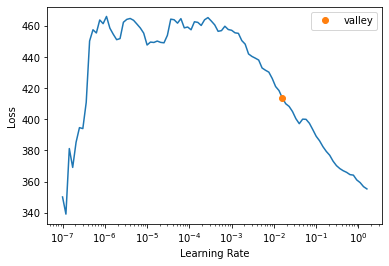

In [3]:
    
df = pd.DataFrame.from_records(games).dropna()
df.head()

test_df = df.query("year == 2021")
train_df = df.query("year != 2021")

excluded = ['id','year','week','home_team','away_team','margin', 'home_points', 'away_points']
cat_features = ['home_conference','away_conference','neutral_site']
cont_features = [c for c in df.columns.to_list() if c not in cat_features and c not in excluded]

splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names="margin",
                    cat_names = cat_features,
                    cont_names = cont_features,
                   splits=splits)

dls = to.dataloaders(bs=64)
dls.show_batch()

learn = tabular_learner(dls, metrics=mae, lr=10e-1)
learn.lr_find()

In [4]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(10)

epoch,train_loss,valid_loss,mae,time
0,276.091736,272.512177,13.050885,00:00
1,268.320557,275.950012,13.183295,00:00
2,267.433105,274.929504,13.083095,00:00
3,262.835449,298.167358,13.668669,00:00
4,264.409149,279.559448,13.163264,00:00
5,259.026917,276.242065,13.120282,00:00
6,255.042038,275.424164,13.058405,00:00
7,259.476135,296.576019,13.577125,00:00
8,260.967926,277.779175,13.166510,00:00
9,263.762024,272.535370,13.024163,00:00


In [5]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(5)

epoch,train_loss,valid_loss,mae,time
0,272.946228,282.791168,13.247707,00:00
1,265.797302,286.284882,13.298274,00:00
2,262.907074,275.392242,13.114382,00:00
3,260.664124,282.997742,13.302330,00:00
4,258.732544,277.306213,13.103447,00:00


In [6]:
learn = tabular_learner(dls, metrics=mae, lr=11e-2)
learn.fit(25)

epoch,train_loss,valid_loss,mae,time
0,286.084259,319.718231,14.184960,00:00
1,271.534363,283.752167,13.369836,00:00
2,268.139771,277.820221,13.143505,00:00
3,268.636932,281.971527,13.231794,00:00
4,265.240570,280.116730,13.250326,00:00
5,259.129486,282.075592,13.203658,00:00
6,264.688416,289.687225,13.514022,00:00
7,264.576752,293.288971,13.584984,00:00
8,263.182892,276.408539,13.098770,00:00
9,262.334412,272.863708,13.030654,00:00


In [7]:
learn.show_results()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,margin,margin_pred
0,11.0,12.0,1.0,-2.941161,0.209775,1.830768,22.0,21.509737
1,7.0,8.0,2.0,0.678848,-0.960982,-1.140388,-17.0,-22.059486
2,8.0,9.0,1.0,-1.717216,0.785026,2.007622,22.0,21.295849
3,10.0,11.0,1.0,1.404444,-0.142667,-0.432970,-13.0,-11.378355
4,8.0,10.0,1.0,-1.127170,0.866047,2.290590,34.0,23.396183
5,5.0,6.0,1.0,0.575191,-0.717918,-0.185374,-4.0,-8.093597
6,3.0,3.0,1.0,0.403759,1.117213,0.239077,-10.0,-0.666074
7,10.0,11.0,1.0,1.352616,-0.187229,-1.564839,-7.0,-25.846907
8,1.0,7.0,1.0,0.355917,-0.491059,-1.140388,-34.0,-17.538301


In [8]:
pdf = test_df.copy()
dl = learn.dls.test_dl(pdf)
pdf['predicted'] = learn.get_preds(dl=dl)[0].numpy()
pdf.head()
pdf[['home_team','away_team','spread','predicted']].round(1)

,home_team,away_team,spread,predicted
4534,Illinois,Nebraska,6.5,8.600000
4535,Fresno State,Connecticut,-27.5,-21.799999
4536,UCLA,Hawai'i,-17.5,-17.600000
4537,New Mexico State,UTEP,9.5,9.400000
4540,UCF,Boise State,-6.5,-7.400000
...,...,...,...,...
5361,Alabama,Georgia,6.5,-2.200000
5362,Wake Forest,Pittsburgh,3.5,2.200000
5363,Iowa,Michigan,12.0,11.100000
5364,California,USC,-4.5,-3.900000


In [9]:
learn.export('talking_tech_neural_net')
learn = load_learner('talking_tech_neural_net')